Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух, например, модель модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

   Данные должны содержать значение цены актива как минимум за каждый день и длительностью как минимум за год.

   Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной
2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

   Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы
3. Обучите модель

    Обучите модели на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей

    Отобразите на графике предсказание моделей и истинные данные
4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

# Решение

In [58]:
import pandas as pd
import matplotlib
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from datetime import datetime


In [59]:
matplotlib.rc('font', size=8)

## Предобработка

В лабораторной работе я использовал датасет с [Kaggle](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset).

Исследуем данные с Agilent Technologies, Inc. Common Stock.

![Agilent Technologies](https://www.moneycontroller.es/upload/aziende/agilent-technologies-inc_20210427125137.png)

In [60]:
df_raw = pd.read_csv('data/raw/stocks/A.csv')
df_raw.index = pd.to_datetime(df_raw.Date)
begin = datetime(2010, 1, 1)
df_raw = df_raw[begin:]

df = df_raw[['Close']].resample('W').mean(numeric_only=True).dropna()  # рассмотрим ряд не по дням, а по неделям
df.head()

,Close
Date,
2010-01-10,22.134478
2010-01-17,21.965665
2010-01-24,21.659514
2010-01-31,20.690987
2010-02-07,20.945637


Рассмотрим цену акций на графике:

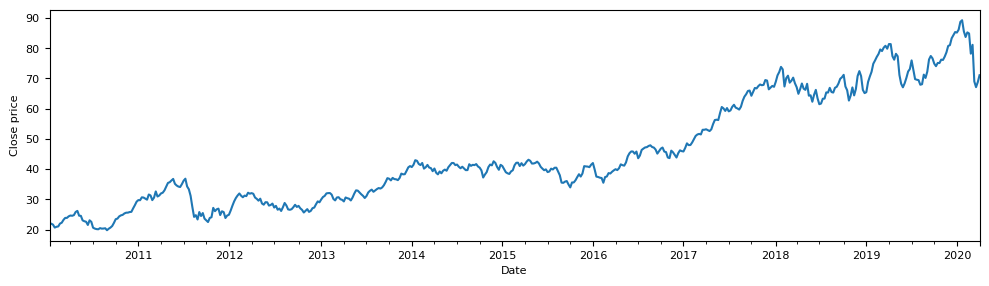

In [61]:
df.Close.plot(ylabel="Close price", figsize=(12, 3));

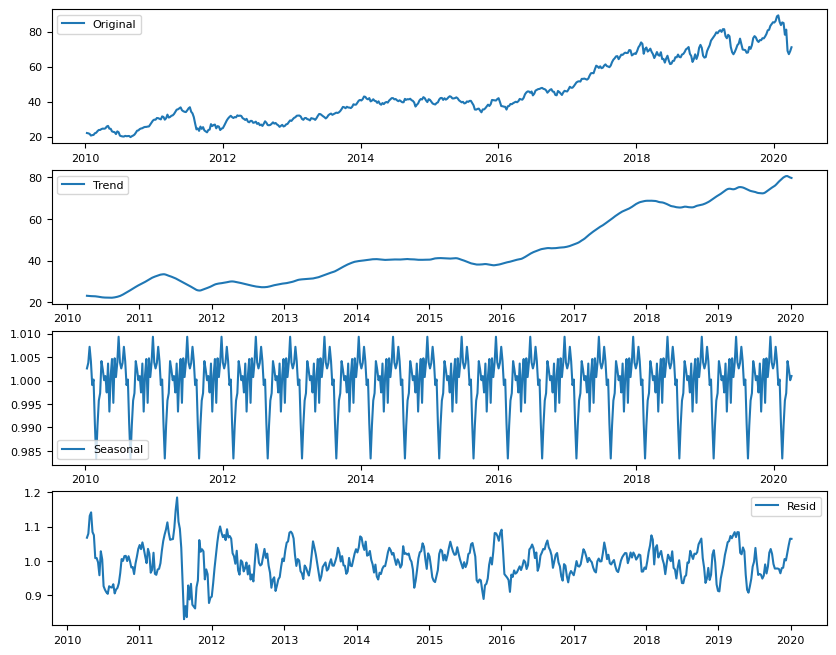

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = seasonal_decompose(df, model='multiplicative', period=26)
trend = decompositions.trend
seasonal = decompositions.seasonal
resid = decompositions.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(df, label='Original')
ax[0].legend(loc='best')
ax[1].plot(trend, label='Trend')
ax[1].legend(loc='best')
ax[2].plot(seasonal, label='Seasonal')
ax[2].legend(loc='best')
ax[3].plot(resid, label='Resid')
ax[3].legend(loc='best')
plt.show()

__Вывод__: Компонент тренда вносит значительный вклад.

## Приведение к стационарному ряду

Применим тест Дики-Фуллера для проверки на стационарность.

In [63]:
def dickey_fuller_test(df):
    adf, p_value, _, _, critical_values, _ = sm.tsa.adfuller(df)
    print('adf:', adf)
    print('p-value:', p_value)
    print('Critical values:', critical_values)
    if adf > critical_values['5%']:
        print('Есть единичные корни, ряд не стационарен')
    else:
        print('Единичных корней нет, ряд стационарен')

In [64]:
dickey_fuller_test(df.Close)

adf: -0.8850761991289756
p-value: 0.7928473038298227
Critical values: {'1%': -3.442678467240966, '5%': -2.8669778698997543, '10%': -2.5696661916864083}
Есть единичные корни, ряд не стационарен


Проверим ряд на *сезонность*, используя автокорреляцию -- корреляцию Пирсона ряда с самим собой, сдвинутого на заданное число отсчетов (лагов). В данном случае выберем, например, 60 лагов.

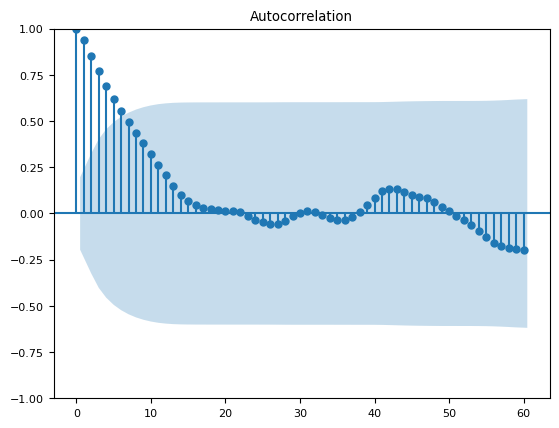

In [65]:
plot_acf(df.Close[-100:], lags=60);

__Вывод__: Сезонность отсутствует.

In [66]:
df['CloseDiff'] = df.Close.diff(1)
dickey_fuller_test(df.CloseDiff.dropna())

adf: -20.830704038381384
p-value: 0.0
Critical values: {'1%': -3.442678467240966, '5%': -2.8669778698997543, '10%': -2.5696661916864083}
Единичных корней нет, ряд стационарен


__Вывод__: Дифференцирование ряда позволяет избавиться от тренда.

## Моделирование

Разделим данные на две группы по 80% и 20%. Первую группу будем использовать для обучения модели, а вторую -- для проверки качества обучения.

In [67]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

### SARIMA

В качестве первой модели используем SARIMA.

In [68]:
import pmdarima as pm

model = pm.auto_arima(df_train.CloseDiff.dropna(), start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=26,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True
                      )
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[26] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(0,0,0)(0,1,0)[26] intercept   : AIC=1429.705, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[26] intercept   : AIC=1328.965, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[26] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[26]             : AIC=1427.751, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[26] intercept   : AIC=1422.149, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[26] intercept   : AIC=1275.929, Time=2.25 sec
 ARIMA(1,0,0)(2,1,1)[26] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(1,0,0)(1,1,1)[26] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(2,1,0)[26] intercept   : AIC=1280.091, Time=1.60 sec
 ARIMA(2,0,0)(2,1,0)[26] intercept   : AIC=1275.780, Time=2.57 sec
 ARIMA(2,0,0)(1,1,0)[26] intercept   : AIC=1328.455, Time=0.85 sec
 ARIMA(2,0,0)(2,1,1)[26] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(2,0,0)(1,1,1)[26] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(3,0,0)(2,1,0)[26] intercept   : AIC=1274.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  427
Model:             SARIMAX(3, 0, 0)x(2, 1, [1], 26)   Log Likelihood                -609.739
Date:                              Tue, 11 Oct 2022   AIC                           1233.478
Time:                                      19:39:02   BIC                           1261.435
Sample:                                           0   HQIC                          1244.548
                                              - 427                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1251      0.042      2.980      0.003       0.043       0.207
ar.L2         -0.0575      0.049     -1.176      0.239      -0.153       0.038
ar.L3          0.0757      0.045      1.672      0.094      -0.013       0.165
ar.S.L26      -0.1400      0.082     -1.710      0.087      -0.300       0.020
ar.S.L52      -0.1265      0.076     -1.664      0.096      -0.276       0.022
ma.S.L26      -0.7676      0.073    -10.501      0.000      -0.911      -0.624
sigma2         1.1282      0.066     17.182      0.000       1.000       1.257
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                50.45
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.51
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
prediction = model.predict(107)


Ряд был продифференцирован, так что для проверки предсказанные данные придется "проинтегрировать".

In [70]:
from pmdarima.utils import diff_inv
import numpy as np


def inv_diff(df_orig_column, df_diff_column, periods):
    value = np.array(df_orig_column[:periods].tolist() + df_diff_column[periods:].tolist())
    inv_diff_vals = diff_inv(value, periods, 1)[periods:]
    return inv_diff_vals


prediction = pd.Series(inv_diff(df_test.Close, prediction, 1), index=df_test.index)

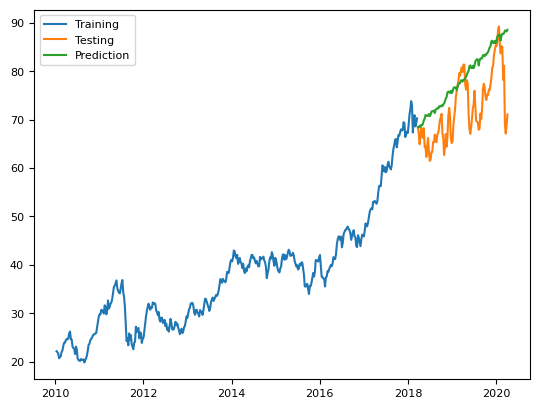

In [71]:
plt.plot(df_train.Close, label='Training')
plt.plot(df_test.Close, label='Testing')
plt.plot(prediction, label='Prediction')
plt.legend()
plt.show()

Оценить качество модели позволяют метрики. Рассмотрим MAPE и MSE:

In [72]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape

print('MAPE: {}%'.format(round(mape(df_test.Close, prediction) * 100, 2)))
print('MSE:', mse(df_test.Close, prediction, squared=False))

MAPE: 9.25%
MSE: 7.875604602777424


### Модель Хольта-Уинтерса

В качестве второй модели будет использовать модель Хольта-Уинтерса.

In [73]:
def predict_with_holter_winter(y, L, alpha, beta, gamma, m):
    n = int(len(y) / L)
    z = [y[0]]
    lx = [y[0]]
    bx = [sum([(float(y[x + L] - y[x]) / L) for x in range(L)]) / L]
    sx = []
    avg = [sum(y[L * x: L * x + L]) / L for x in range(n)]
    for x in range(L):
        acc = 0.0
        for j in range(n):
            acc += y[L * j + x] - avg[j]
        sx.append(acc / n)
    for i in range(1, len(y)):
        lx.append(alpha * (y[i] - sx[i % L]) + (1 - alpha) * (lx[-1] + bx[-1]))
        bx.append(beta * (lx[-1] - lx[-2]) + bx[-1] * (1 - beta))
        sx[i % L] = gamma * (y[i] - lx[-1]) + (1 - gamma) * sx[i % L]
        z.append(lx[-1] + bx[-1] + sx[i % L])
    for i in range(len(y), len(y) + m):
        z.append(lx[-1] + (i - len(y) + 1) * bx[-1] + sx[i % L])
    return np.array(z[-m:])

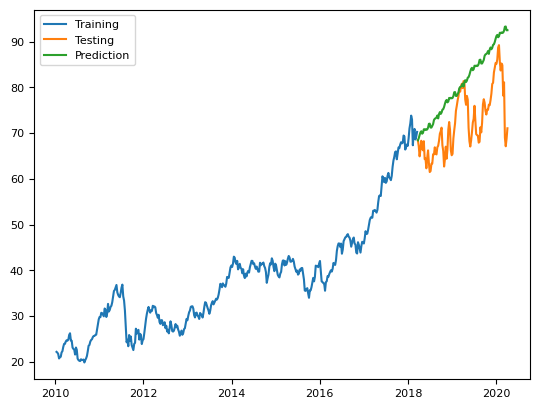

In [74]:
prediction = predict_with_holter_winter(df_train.CloseDiff.dropna(), 30, 0.005, 0.022, 0.2, 107)
prediction = pd.Series(inv_diff(df_test.Close, prediction, 1), index=df_test.index)

plt.plot(df_train.Close, label='Training')
plt.plot(df_test.Close, label='Testing')
plt.plot(prediction, label='Prediction')
plt.legend()
plt.show()

In [75]:
print('MAPE: {}%'.format(round(mape(df_test.Close, prediction) * 100, 2)))
print('MSE:', mse(df_test.Close, prediction, squared=False))

MAPE: 12.04%
MSE: 10.038789460213154


__Вывод__: С подобранными мной параметрами модель Хольта-Уинтерса сравнима по качеству с SARIMA, хоть и чуть-чуть уступает.